#Heart Failure Prediction  using Tensorflow

This task demonstrates how to do structured data classification, starting from a raw CSV file. Our data includes both numerical and categorical features. We will use Keras preprocessing layers to normalize the numerical features and vectorize the categorical ones.


In [2]:
#Setup
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.7.0


In [10]:
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
data= pd.read_csv(file_url)

In [11]:
data.head()

age  sex  cp  trestbps  chol  ...  oldpeak  slope  ca        thal  target
0   63    1   1       145   233  ...      2.3      3   0       fixed       0
1   67    1   4       160   286  ...      1.5      2   3      normal       1
2   67    1   4       120   229  ...      2.6      2   2  reversible       0
3   37    1   3       130   250  ...      3.5      3   0      normal       0
4   41    0   2       130   204  ...      1.4      1   0      normal       0

[5 rows x 14 columns]

In [12]:
data.describe().T.style.background_gradient(cmap='Blues')

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(1), int64(12), object(1)
memory usage: 33.3+ KB


In [14]:
dataframe.shape

(303, 14)

The last column, "target", indicates whether the patient has a heart disease (1) or not (0).

Let's split the data into a training and validation set:

In [15]:
val_dataframe = data.sample(frac=0.2, random_state=1337)
train_dataframe = data.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 242 samples for training and 61 for validation


Let's generate tf.data.Dataset objects for each dataframe:

In [17]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

Each Dataset yields a tuple (input, target) where input is a dictionary of features and target is the value 0 or 1:

In [18]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'age': <tf.Tensor: shape=(), dtype=int64, numpy=54>, 'sex': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'cp': <tf.Tensor: shape=(), dtype=int64, numpy=4>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=110>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=206>, 'fbs': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'restecg': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=108>, 'exang': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>, 'slope': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'ca': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'thal': <tf.Tensor: shape=(), dtype=string, numpy=b'normal'>}
Target: tf.Tensor(1, shape=(), dtype=int64)


Let's batch the datasets:

In [19]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

#Feature preprocessing with Keras layers
The following features are categorical features encoded as integers:

sex
cp
fbs
restecg
exang
ca
We will encode these features using one-hot encoding. We have two options here:

Use CategoryEncoding(), which requires knowing the range of input values and will error on input outside the range.
Use IntegerLookup() which will build a lookup table for inputs and reserve an output index for unkown input values.
For this example, we want a simple solution that will handle out of range inputs at inference, so we will use IntegerLookup().

We also have a categorical feature encoded as a string: thal. We will create an index of all possible features and encode output using the StringLookup() layer.

Finally, the following feature are continuous numerical features:

age
trestbps
chol
thalach
oldpeak
slope
For each of these features, we will use a Normalization() layer to make sure the mean of each feature is 0 and its standard deviation is 1.

Below, we define 3 utility functions to do the operations:

encode_numerical_feature to apply featurewise normalization to numerical features.
encode_string_categorical_feature to first turn string inputs into integer indices, then one-hot encode these integer indices.
encode_integer_categorical_feature to one-hot encode integer categorical features.

In [20]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

Build a model
With this done, we can create our end-to-end model:



In [21]:
# Categorical features encoded as integers
sex = keras.Input(shape=(1,), name="sex", dtype="int64")
cp = keras.Input(shape=(1,), name="cp", dtype="int64")
fbs = keras.Input(shape=(1,), name="fbs", dtype="int64")
restecg = keras.Input(shape=(1,), name="restecg", dtype="int64")
exang = keras.Input(shape=(1,), name="exang", dtype="int64")
ca = keras.Input(shape=(1,), name="ca", dtype="int64")

# Categorical feature encoded as string
thal = keras.Input(shape=(1,), name="thal", dtype="string")

# Numerical features
age = keras.Input(shape=(1,), name="age")
trestbps = keras.Input(shape=(1,), name="trestbps")
chol = keras.Input(shape=(1,), name="chol")
thalach = keras.Input(shape=(1,), name="thalach")
oldpeak = keras.Input(shape=(1,), name="oldpeak")
slope = keras.Input(shape=(1,), name="slope")

all_inputs = [
    sex,
    cp,
    fbs,
    restecg,
    exang,
    ca,
    thal,
    age,
    trestbps,
    chol,
    thalach,
    oldpeak,
    slope,
]

# Integer categorical features
sex_encoded = encode_categorical_feature(sex, "sex", train_ds, False)
cp_encoded = encode_categorical_feature(cp, "cp", train_ds, False)
fbs_encoded = encode_categorical_feature(fbs, "fbs", train_ds, False)
restecg_encoded = encode_categorical_feature(restecg, "restecg", train_ds, False)
exang_encoded = encode_categorical_feature(exang, "exang", train_ds, False)
ca_encoded = encode_categorical_feature(ca, "ca", train_ds, False)

# String categorical features
thal_encoded = encode_categorical_feature(thal, "thal", train_ds, True)

# Numerical features
age_encoded = encode_numerical_feature(age, "age", train_ds)
trestbps_encoded = encode_numerical_feature(trestbps, "trestbps", train_ds)
chol_encoded = encode_numerical_feature(chol, "chol", train_ds)
thalach_encoded = encode_numerical_feature(thalach, "thalach", train_ds)
oldpeak_encoded = encode_numerical_feature(oldpeak, "oldpeak", train_ds)
slope_encoded = encode_numerical_feature(slope, "slope", train_ds)

all_features = layers.concatenate(
    [
        sex_encoded,
        cp_encoded,
        fbs_encoded,
        restecg_encoded,
        exang_encoded,
        slope_encoded,
        ca_encoded,
        thal_encoded,
        age_encoded,
        trestbps_encoded,
        chol_encoded,
        thalach_encoded,
        oldpeak_encoded,
    ]
)
x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

Let's visualize our connectivity graph:

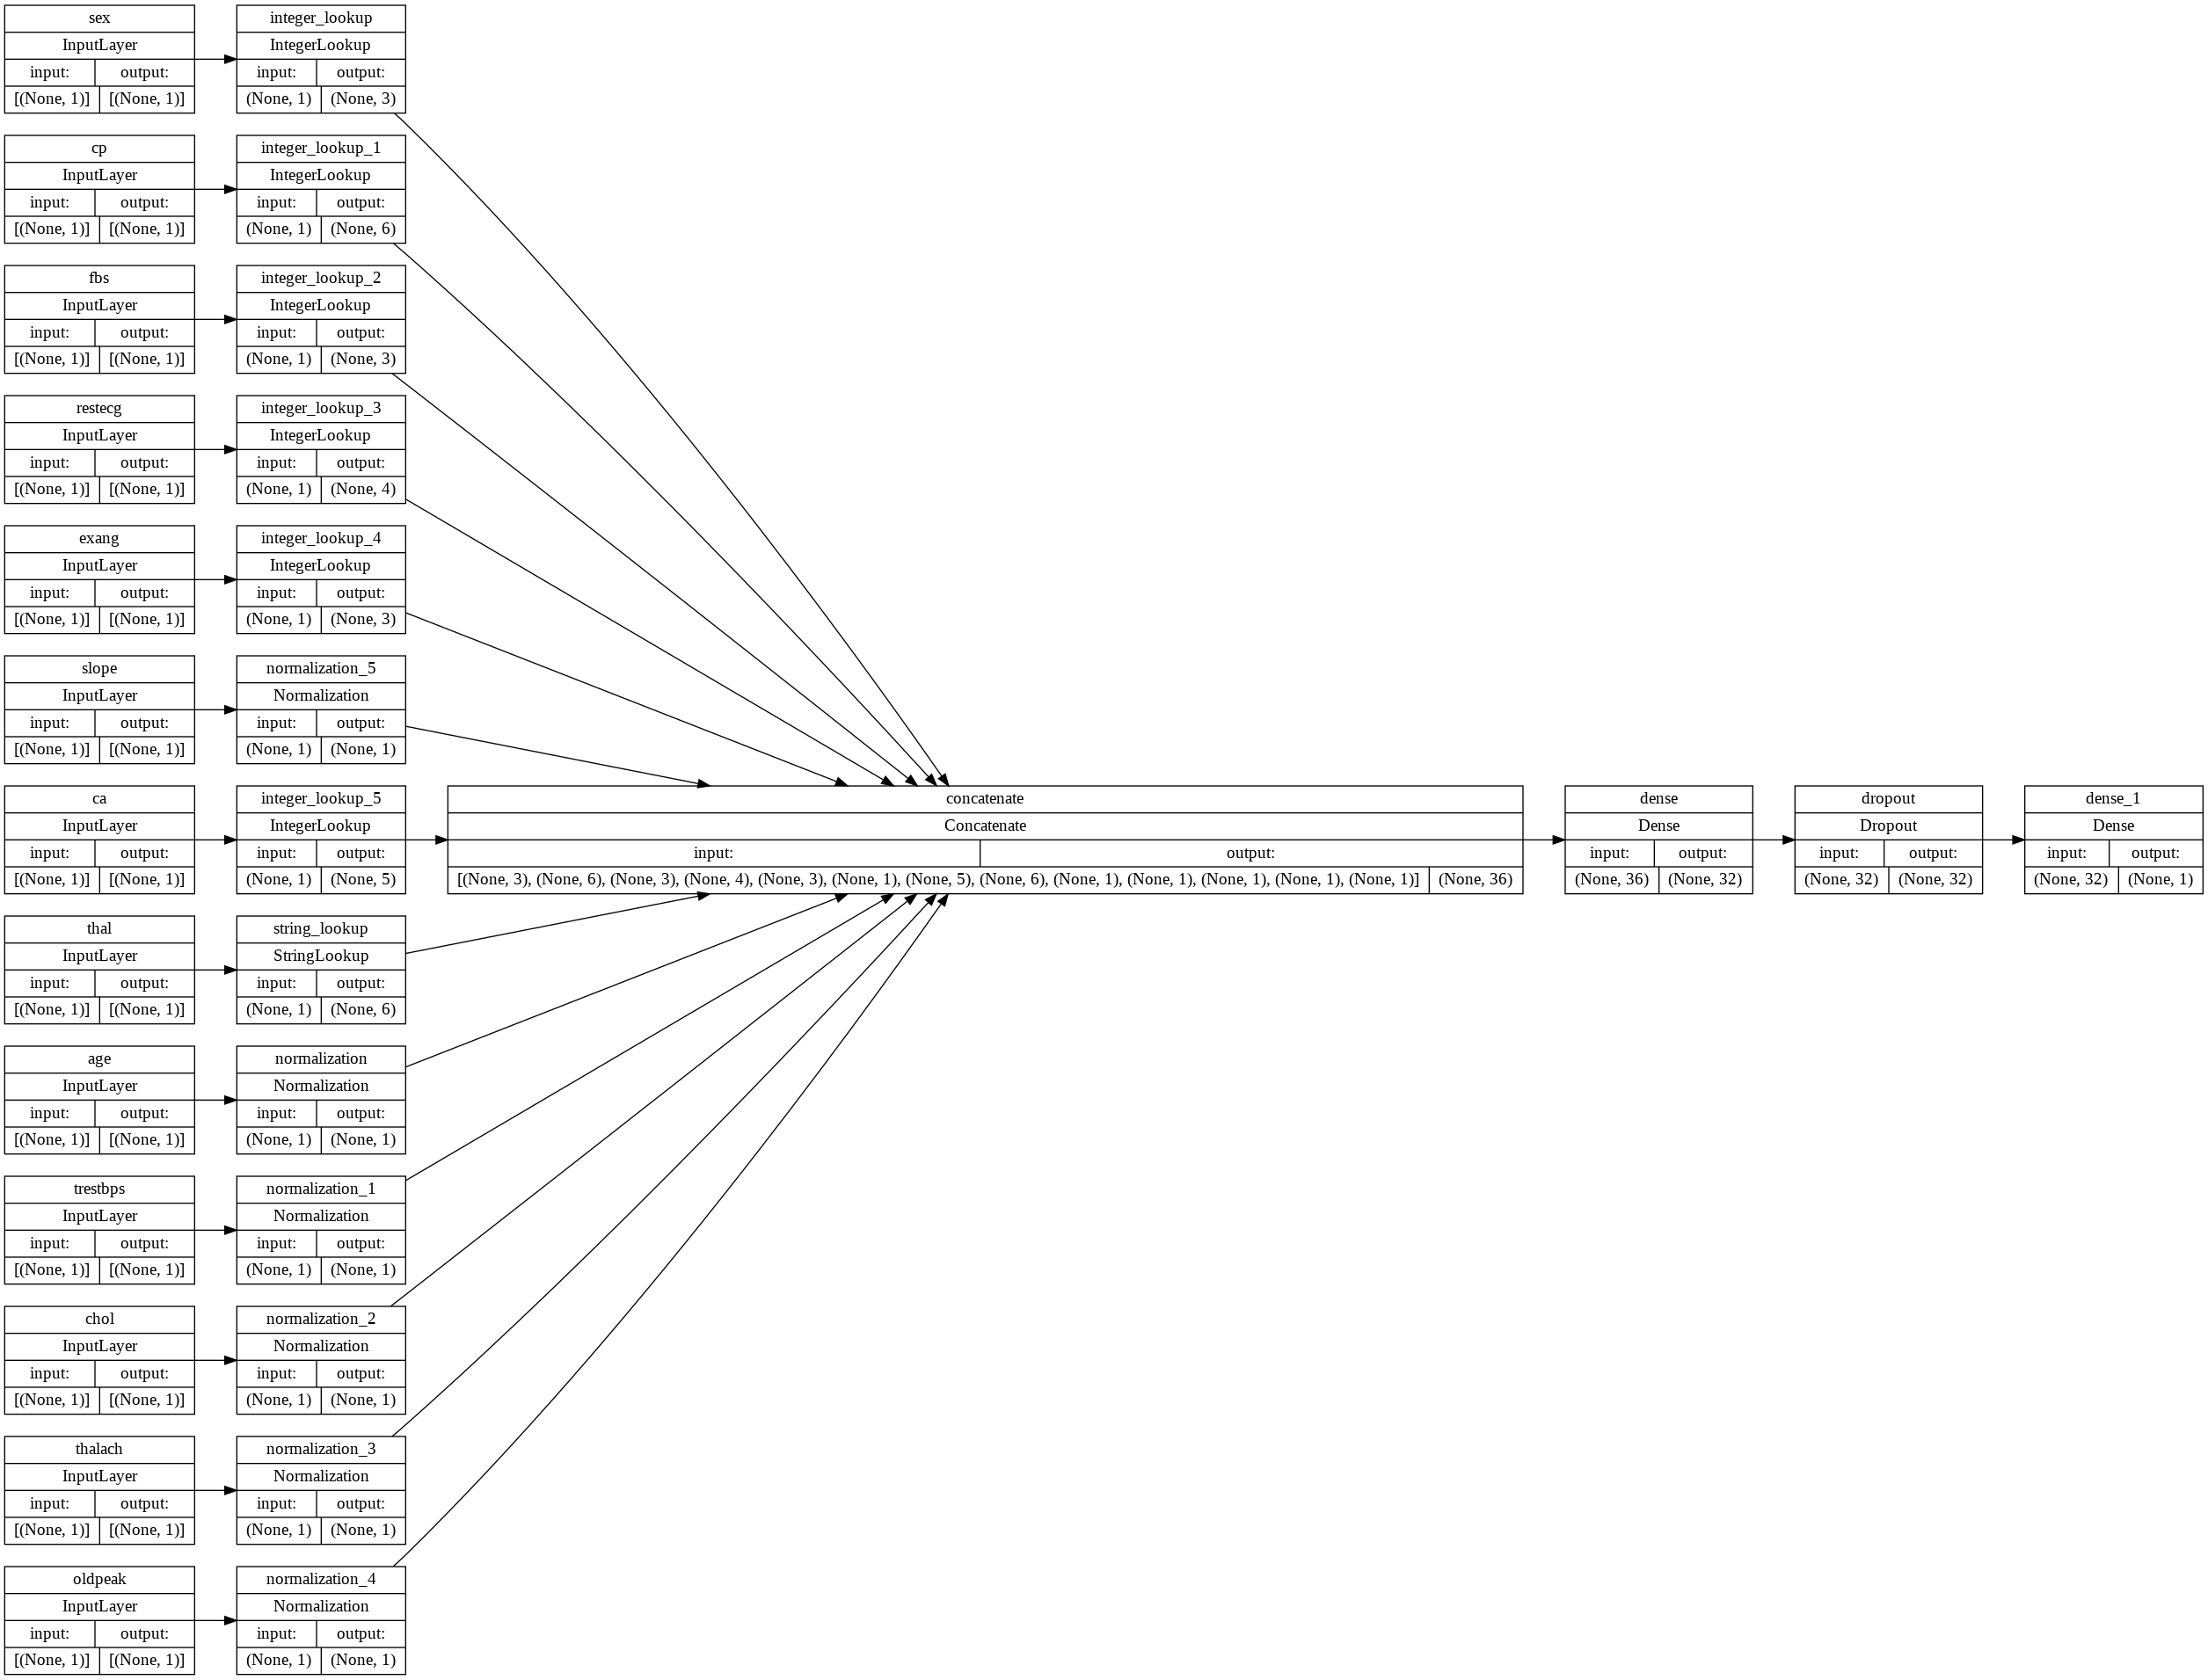

In [23]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [25]:
model.fit(train_ds, epochs=100, validation_data=val_ds)

Epoch 1/100
8/8 [==============================] - 0s 7ms/step - loss: 0.2723 - accuracy: 0.8926 - val_loss: 0.3939 - val_accuracy: 0.7869
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.2731 - accuracy: 0.8843 - val_loss: 0.3950 - val_accuracy: 0.7869
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 0.3210 - accuracy: 0.8636 - val_loss: 0.3940 - val_accuracy: 0.7869
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 0.2695 - accuracy: 0.8884 - val_loss: 0.3943 - val_accuracy: 0.7869
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 0.2562 - accuracy: 0.8884 - val_loss: 0.3955 - val_accuracy: 0.7869
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 0.2758 - accuracy: 0.9008 - val_loss: 0.3966 - val_accuracy: 0.7869
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 0.2602 - accuracy: 0.9215 - val_loss: 0.3965 - val_accuracy: 0.7869
Epoch 8/100
8/8 [==========

In [29]:


def predit_target(sample):
    input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
    predictions = model.predict(input_dict)

    print(
        "This particular patient had a %.1f percent probability "
        "of having a heart disease, as evaluated by our model." % (100 * predictions[0][0],)
    )

In [33]:
sample1 = {
    "age": 60,
    "sex": 1,
    "cp": 1,
    "trestbps": 145,
    "chol": 233,
    "fbs": 1,
    "restecg": 2,
    "thalach": 150,
    "exang": 0,
    "oldpeak": 2.3,
    "slope": 3,
    "ca": 0,
    "thal": "fixed",
}

In [34]:
sample2 = {
    "age": 67,
    "sex": 1,
    "cp": 4,
    "trestbps": 160,
    "chol": 286,
    "fbs": 0,
    "restecg": 2,
    "thalach": 108,
    "exang": 1,
    "oldpeak": 2.3,
    "slope": 2,
    "ca": 3,
    "thal": "normal",
}

""" 67	1	4	160	286	0	2	108	1	1.5	2	3	normal	target : 1 """

' 67\t1\t4\t160\t286\t0\t2\t108\t1\t1.5\t2\t3\tnormal\ttarget : 1 '

In [35]:
predit_target(sample1)

This particular patient had a 6.2 percent probability of having a heart disease, as evaluated by our model.


In [36]:
predit_target(sample2)

This particular patient had a 84.7 percent probability of having a heart disease, as evaluated by our model.
